# Elastic-Inspired Hybrid Anomaly Detection Pipeline

In [13]:
# === Improt ===
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from statsmodels.tsa.seasonal import STL
from pyod.models.ecod import ECOD
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
import joblib

# === CONFIG ===

In [ ]:

train_csv_path = "../test_csv/normal_2.csv"
test_csv_path = "../test_csv/motor_temp_low.csv"
window_size = 30
epochs = 100
batch_size = 128
contamination = 0.05


# === LOAD & PREPARE DATA ===

In [15]:
state_batch_24h = [
    "00:00 off",
    "01:30 idle",
    "02:00 run",
    "08:00 off",
    "09:00 idle",
    "09:30 run",
    "09:45 idle",
    "10:00 run",
    "17:00 idle",
    "17:30 run",
    "23:59 run"
]

def apply_state_batch(df, state_batch, default_state="off"):
    transitions = []
    for entry in state_batch:
        time_str, state = entry.rsplit(" ", 1)
        time_obj = datetime.strptime(time_str, "%H:%M").time() 
        transitions.append((time_obj, state.lower()))

    df = df.copy()
    df["state"] = default_state
    df["state"] = df["state"].astype("object")  # or "string"
    times = df.index.time

    current_state = default_state
    next_idx = 0

    for i, t in enumerate(times):
        while next_idx < len(transitions) and t >= transitions[next_idx][0]:
            current_state = transitions[next_idx][1]
            next_idx += 1
        df.iat[i, df.columns.get_loc("state")] = current_state

    return df


def prepare_data(file_path, state_batch):
    df = pd.read_csv(file_path, parse_dates=["timestamp"])
    pivot_df = df.pivot(index="timestamp", columns="sensor", values="feature_0").interpolate().dropna()
    pivot_df = apply_state_batch(pivot_df, state_batch)

    # Encode state to numerical
    pivot_df["state_encoded"] = pivot_df["state"].astype("category").cat.codes

    return pivot_df

def create_sequences(data, window_size):
    X, timestamps = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        timestamps.append(i + window_size - 1)
    return np.array(X), timestamps



In [16]:
# Step 1: Load and prepare raw data with state_batch
train_df = prepare_data(train_csv_path, state_batch_24h)
test_df = prepare_data(test_csv_path, state_batch_24h)

# Step 2: Separate sensor features and state_encoded
sensor_cols = [col for col in train_df.columns if col not in ["state", "state_encoded"]]

# Split data into sensors + state
train_sensor = train_df[sensor_cols]
test_sensor = test_df[sensor_cols]

train_state = train_df["state_encoded"].values.reshape(-1, 1)
test_state = test_df["state_encoded"].values.reshape(-1, 1)

# Step 3: Scale sensor features only
scaler = RobustScaler()
train_scaled_sensor = scaler.fit_transform(train_sensor)
test_scaled_sensor = scaler.transform(test_sensor)

# Step 4: Create sequences for sensor data using your existing function
X_train_sensor, train_times = create_sequences(train_scaled_sensor, window_size)
X_test_sensor, test_times = create_sequences(test_scaled_sensor, window_size)

# Determine exactly how many sequences we have for sensors
n_train_sequences = X_train_sensor.shape[0]  # Should be 43140
n_test_sequences = X_test_sensor.shape[0]

# Step 5: Create sequences for state data with EXACTLY the same number
X_train_state = np.zeros((n_train_sequences, window_size, 1), dtype=np.int64)
X_test_state = np.zeros((n_test_sequences, window_size, 1), dtype=np.int64)

# Fill the arrays with the correct state values
for i in range(n_train_sequences):
    X_train_state[i, :, 0] = train_state[i:i+window_size, 0]

for i in range(n_test_sequences):
    X_test_state[i, :, 0] = test_state[i:i+window_size, 0]

print("X_train_sensor shape:", X_train_sensor.shape)
print("X_train_state shape:", X_train_state.shape)
print("X_train_state dtype:", X_train_state.dtype)
print(train_df.head())

X_train_sensor shape: (43140, 30, 4)
X_train_state shape: (43140, 30, 1)
X_train_state dtype: int64
sensor                  power       rpm  temperature  vibration state  \
timestamp                                                               
2025-04-07 00:00:00  4.626855  2.355440         22.0   7.854178   off   
2025-04-07 00:01:00  4.136541  2.328874         22.0   7.535466   off   
2025-04-07 00:02:00  5.120662  2.358879         22.0   7.746224   off   
2025-04-07 00:03:00  4.400668  2.600601         22.0   7.582647   off   
2025-04-07 00:04:00  4.868998  2.469488         22.0   7.469315   off   

sensor               state_encoded  
timestamp                           
2025-04-07 00:00:00              1  
2025-04-07 00:01:00              1  
2025-04-07 00:02:00              1  
2025-04-07 00:03:00              1  
2025-04-07 00:04:00              1  


# === STAGE 1: UNSUPERVISED ENSEMBLE ON TRAINING DATA ===

In [17]:
# Flatten each window (sequence) into 1D vector - but first combine them temporarily
# Combine sensor and state data for unsupervised detection

X_train_combined = np.dstack([X_train_sensor, X_train_state])  # Shape: [samples, seq_len, features+1]
flat_train = X_train_combined.reshape(X_train_combined.shape[0], -1)
sensor_features = ["power", "rpm", "temperature", "vibration"]
combined_resid_scores = np.zeros(len(flat_train))

# Loop through each feature and apply STL
for feature in sensor_features:
    # Apply STL to this feature
    stl_series = train_df[feature]
    stl = STL(stl_series, period=24)
    
    try:
        resid = np.abs(stl.fit().resid)
        # Normalize residuals
        resid = (resid - resid.min()) / (resid.max() - resid.min())
        # Align with flat_train length
        feature_resid_scores = resid[-len(flat_train):]
        
        # Add to combined scores (with equal weighting)
        combined_resid_scores += feature_resid_scores / len(sensor_features)
    except Exception as e:
        print(f"Error processing {feature}: {e}")
        # If one feature fails, continue with others

# -- Isolation Forest
iso = IsolationForest(contamination=contamination, random_state=42)
iso_scores = -iso.fit_predict(flat_train)

# -- One-Class SVM
svm = OneClassSVM(nu=contamination)
svm_scores = -svm.fit_predict(flat_train)

# -- DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_scores = (dbscan.fit_predict(flat_train) == -1).astype(int)

# -- ECOD
ecod = ECOD(contamination=contamination)
ecod_scores = ecod.fit_predict(flat_train)

# -- Combine ensemble scores (you can tune the weights)
unsup_score = (
    0.25 * combined_resid_scores +
    0.25 * iso_scores +
    0.20 * svm_scores +
    0.15 * dbscan_scores +
    0.15 * ecod_scores
)

# -- Thresholding
threshold_unsup = np.percentile(unsup_score, 100 * (1 - contamination))
pseudo_labels = (unsup_score > threshold_unsup).astype(int)

g:\Conda\envs\python3.12\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


# === PLOT PSEUDO LABELS ON TRAINING DATA ===

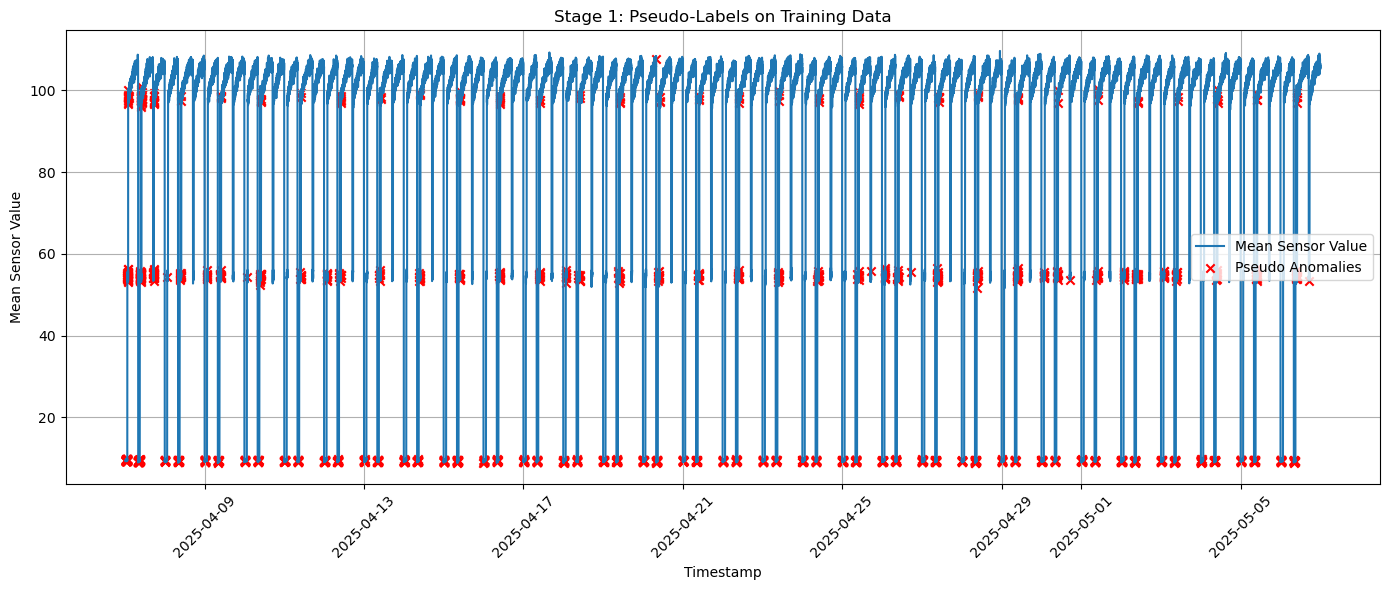

In [18]:
# === PLOT PSEUDO LABELS ON TRAINING DATA ===
sensor_columns = [col for col in train_df.columns if col not in ["state", "state_encoded"]]
mean_values = train_df[sensor_columns].mean(axis=1).values
plot_series = mean_values[train_times]      # values that match the windowed sequences

# Convert train_times (ints) into actual timestamps
train_timestamps = train_df.index[train_times]

# Now plot
plt.figure(figsize=(14, 6))
plt.plot(train_timestamps, plot_series, label="Mean Sensor Value")

# Overlay pseudo anomalies
anomaly_times = train_timestamps[pseudo_labels == 1]
anomaly_values = plot_series[pseudo_labels == 1]

plt.scatter(anomaly_times, anomaly_values, color='red', marker='x', label='Pseudo Anomalies')
plt.title("Stage 1: Pseudo-Labels on Training Data")
plt.xlabel("Timestamp")
plt.ylabel("Mean Sensor Value")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# === STAGE 2: LSTM-AE with ATTENTION ===

In [19]:


# -- Attention layer (unchanged)
class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.attn = nn.Linear(input_dim, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        weights = self.softmax(self.attn(x))  # (batch, seq_len, 1)
        context = torch.sum(weights * x, dim=1, keepdim=True)
        return context.repeat(1, x.shape[1], 1)

# -- LSTM Autoencoder with embedded state input - MODIFIED to take separate inputs
class LSTMAEWithState(nn.Module):
    def __init__(self, sensor_dim, state_vocab_size, state_embed_dim=3):
        super().__init__()
        self.sensor_dim = sensor_dim
        self.state_embed = nn.Embedding(state_vocab_size, state_embed_dim)

        self.lstm1 = nn.LSTM(sensor_dim + state_embed_dim, 64, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.attn = AttentionLayer(64)
        self.lstm2 = nn.LSTM(64, 32, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.out = nn.Linear(32, sensor_dim)  # only reconstruct sensor values

    def forward(self, sensor_input, state_input):
        # sensor_input: [batch, seq_len, sensor_dim]
        # state_input: [batch, seq_len]
        
        state_embed = self.state_embed(state_input)        # (batch, seq_len, embed_dim)
        x_cat = torch.cat([sensor_input, state_embed], dim=2)  # concat along feature dim
        
        x, _ = self.lstm1(x_cat)
        x = self.dropout1(x)
        x = self.attn(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        return self.out(x)


In [20]:
# -- Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -- Prepare sample weights (pseudo-labeled anomalies get higher weight)
train_weights = np.ones(len(X_train_sensor))
train_weights[pseudo_labels == 1] = 3.0

# -- Get dimensions for model
sensor_dim = X_train_sensor.shape[2]  # all features are sensors
state_vocab_size = int(X_train_state.max()) + 1  # categorical range of state

# -- Wrap into DataLoader (convert to tensor, ensure state is int)
X_train_sensor_tensor = torch.tensor(X_train_sensor, dtype=torch.float32)
X_train_state_tensor = torch.tensor(X_train_state, dtype=torch.long)  # Long tensor for embedding
train_dataset = torch.utils.data.TensorDataset(
    X_train_sensor_tensor, 
    X_train_state_tensor.squeeze(2),  # Remove the last dimension if it's [batch, seq, 1]
    torch.tensor(train_weights, dtype=torch.float32)
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("State min:", X_train_state.min())
print("State max:", X_train_state.max())
print("Expected vocab size:", state_vocab_size)

# -- Initialize model
model = LSTMAEWithState(sensor_dim, state_vocab_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss(reduction='none')  # manual reduction with weights


State min: 0
State max: 2
Expected vocab size: 3


In [21]:

# -- Training loop
print("Training LSTM Autoencoder with State Embedding...")
model.train()
for epoch in range(epochs):
    total_loss = 0
    for sensor_batch, state_batch, weight_batch in train_loader:
        sensor_batch = sensor_batch.to(device)
        state_batch = state_batch.to(device)
        weight_batch = weight_batch.to(device)

        optimizer.zero_grad()
        recon = model(sensor_batch, state_batch)

        # Compute loss on sensor reconstruction
        loss_per_sample = loss_fn(recon, sensor_batch).mean(dim=(1, 2)) * weight_batch
        loss = loss_per_sample.mean()

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

Training LSTM Autoencoder with State Embedding...
Epoch 1/100, Loss: 67.6817
Epoch 2/100, Loss: 35.4493
Epoch 3/100, Loss: 20.1261
Epoch 4/100, Loss: 11.6649
Epoch 5/100, Loss: 6.8691
Epoch 6/100, Loss: 4.5647
Epoch 7/100, Loss: 3.5831
Epoch 8/100, Loss: 3.1771
Epoch 9/100, Loss: 2.9641
Epoch 10/100, Loss: 2.8416
Epoch 11/100, Loss: 2.7391
Epoch 12/100, Loss: 2.6044
Epoch 13/100, Loss: 2.5961
Epoch 14/100, Loss: 2.4745
Epoch 15/100, Loss: 2.3721
Epoch 16/100, Loss: 2.3764
Epoch 17/100, Loss: 2.3415
Epoch 18/100, Loss: 2.1733
Epoch 19/100, Loss: 2.3804
Epoch 20/100, Loss: 2.1081
Epoch 21/100, Loss: 2.0840
Epoch 22/100, Loss: 2.2791
Epoch 23/100, Loss: 2.0909
Epoch 24/100, Loss: 1.9370
Epoch 25/100, Loss: 1.9171
Epoch 26/100, Loss: 1.9412
Epoch 27/100, Loss: 1.8303
Epoch 28/100, Loss: 1.7591
Epoch 29/100, Loss: 1.7951
Epoch 30/100, Loss: 1.7885
Epoch 31/100, Loss: 1.7763
Epoch 32/100, Loss: 1.6219
Epoch 33/100, Loss: 1.6712
Epoch 34/100, Loss: 1.5806
Epoch 35/100, Loss: 1.6463
Epoch 36/1

# === EVALUATION ===

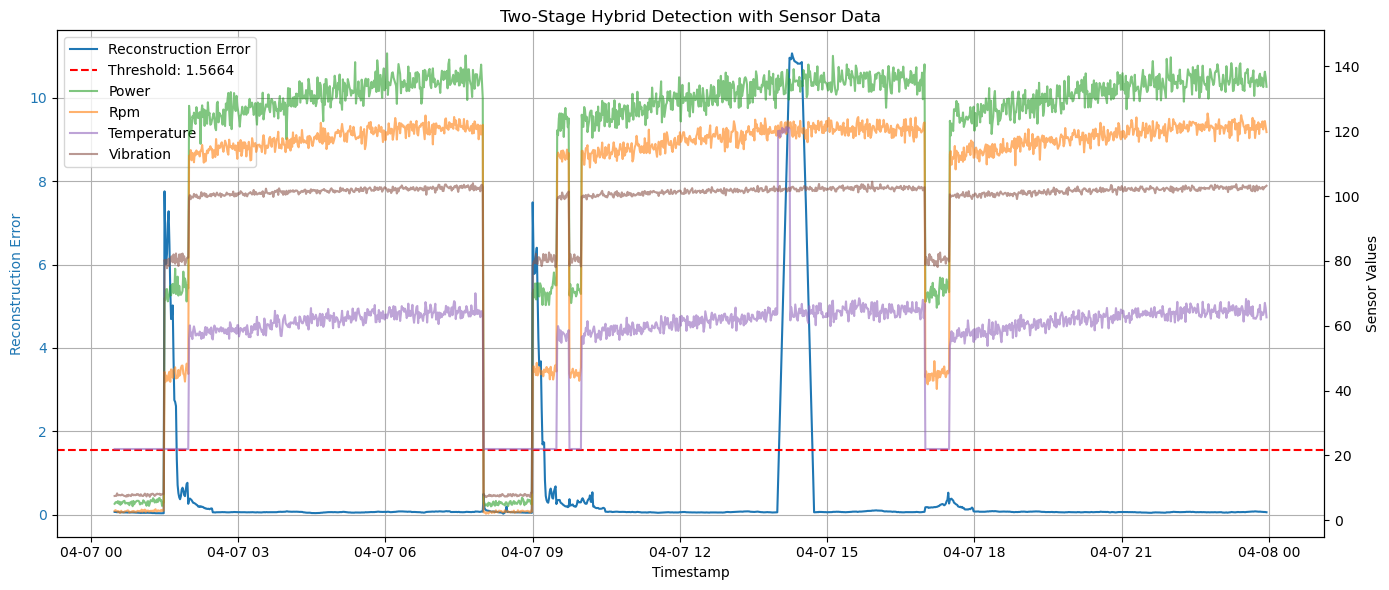

In [23]:
joblib.dump(model, "saved_models/lstm_ae_model_state_included.pkl")
model.eval()
X_test_sensor_tensor = torch.tensor(X_test_sensor, dtype=torch.float32).to(device)
X_test_state_tensor = torch.tensor(X_test_state, dtype=torch.long).to(device)

# Remove extra dimension from state if it's [batch, seq, 1]
if len(X_test_state_tensor.shape) == 3:
    X_test_state_tensor = X_test_state_tensor.squeeze(2)

with torch.no_grad():
    recon = model(X_test_sensor_tensor, X_test_state_tensor).cpu().numpy()

# Calculate reconstruction error (only on sensor part)
recon_error = np.mean((X_test_sensor - recon) ** 2, axis=(1,2))

threshold = np.percentile(recon_error, 100 * (1 - contamination))
preds = (recon_error > threshold).astype(int)

# === PLOT ===
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot reconstruction error on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Reconstruction Error', color=color)
ax1.plot(test_df.index[test_times], recon_error, color=color, label="Reconstruction Error")
ax1.axhline(threshold, color='red', linestyle='--', label=f"Threshold: {threshold:.4f}")
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the test data
ax2 = ax1.twinx()
ax2.set_ylabel('Sensor Values')

# Plot each sensor with a different color
sensor_columns = ['power', 'rpm', 'temperature', 'vibration']  # Adjust based on your columns
colors = ['tab:green', 'tab:orange', 'tab:purple', 'tab:brown']

for i, sensor in enumerate(sensor_columns):
    if sensor in test_df.columns:
        ax2.plot(test_df.index[test_times], test_df[sensor].values[test_times], 
                 color=colors[i % len(colors)], alpha=0.6, label=sensor.capitalize())

ax2.tick_params(axis='y')

# Title and grid
plt.title("Two-Stage Hybrid Detection with Sensor Data")
ax1.grid(True)

# Create combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()